# Linear Regression Model for Predicting House Prices

# Housing Prices Prediction Project

This Kaggle dataset contains approximately **3,000 property listings**, each with **79 different features** plus the target variable **Sale Price**.  
The goal is to perform EDA, clean and preprocess the data, then build a linear model capable of predicting home prices accurately.

## Project Workflow

### 1. Exploratory Data Analysis (EDA)
- Examine the structure of the dataset.
- Analyze distributions, correlations, and feature relationships.
- Identify missing values and potential issues.

### 2. Data Preprocessing
#### 2.1 Handling Skewness and Outliers
- Apply transformations to skewed numerical features.
- Detect and address extreme outliers to improve model stability.

#### 2.2 Encoding Categorical Data
- Convert categorical variables into numeric formats (e.g., one-hot encoding).

#### 2.3 Imputing Missing Values
- Fill missing entries using suitable imputation techniques.

### 3. Modelling
- Train and evaluate a linear model for predicting housing prices.
- Tune and validate the model for best performance.

### 4. Submission
- Generate predictions for the test set.
- Prepare and submit the final CSV file to Kaggle.



In [1]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Exploratory Data Analysis (EDA)

In this initial investigations on data will be performed to to develop an understanding of the data, discover patterns and spot anomalies.

In [ ]:
# Load the datasets into DataFrames

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# check the number of records and columns in both of datasets
print('No. of records in train dataset: ', len(train.index))
print('No. of columns in train dataset: ', len(train.columns))
print('No. of records in test dataset: ', len(test.index))
print('No. of columns in test dataset: ', len(test.columns))

No. of records in train dataset:  1460
No. of columns in train dataset:  81
No. of records in test dataset:  1459
No. of columns in test dataset:  80


In [6]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 7829
Total missing values in test set 7878


In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The code above indicates that the average sale price of a house is approximately **$180,000**, with most prices ranging between **$130,000 and $215,000**.  

The next step is to visualize and analyze the relationships between features and the target variable by examining their **correlations**. This will help identify which attributes have the strongest impact on predicting home prices.


In [9]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

The features most strongly correlated with **SalePrice** were:

- **Overall Quality (79%)**
- **Above-Ground Living Area – GrLivArea (71%)**
- **Garage Area (64%)**
- **Garage Cars – Number of Car Spaces (62%)**

These variables show the strongest linear relationships with the target.  

The next step is to create **scatter plots** of each of these features against `SalePrice` to visually inspect the presence of outliers.  
Outliers are important to detect because they can distort a linear regression model by pulling the estimated regression line away from the true underlying trend.


Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

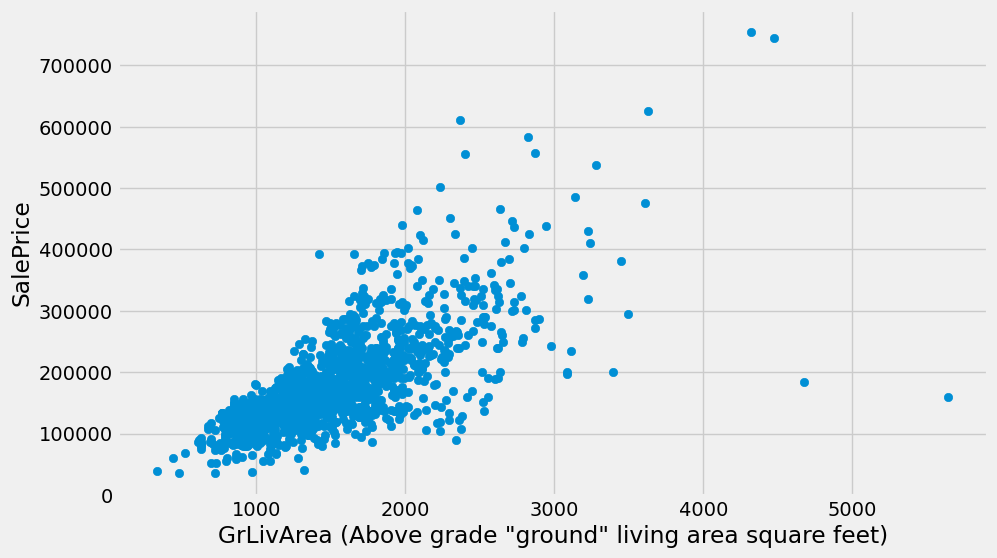

In [10]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

At first glance, there are increases in living area correspond to increases in price, with few outliers.

Text(0.5, 0, 'GarageArea')

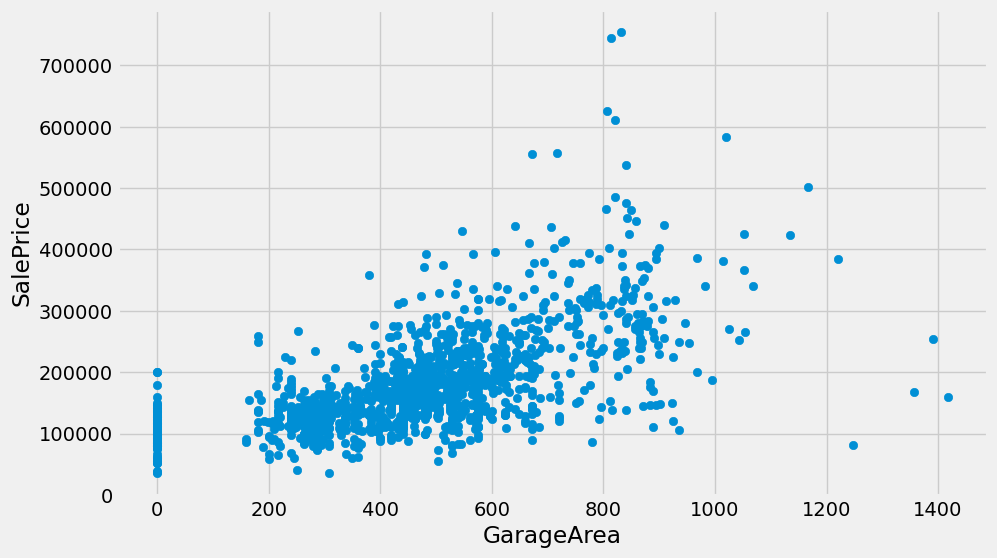

In [11]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

# Data Preprocessing

In this section, the data is prepared through various steps—such as transformation, encoding, and handling missing values—to make it suitable for building and training a machine learning model.  

As part of the preprocessing, I manually removed a small number of extreme outliers from the dataset. These observations showed unusually large discrepancies compared to the rest of the data and were negatively affecting the model’s ability to learn a stable relationship. Removing them results in a cleaner dataset and a better overall fit for the regression model.


In [12]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [13]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [14]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [15]:
# do the same with test data
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index, axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [16]:
# encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [17]:
# do the same for testset
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

In [18]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [19]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [20]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

# Modelling

I will perform a simple linear regression on the dataset to predict house prices. To train out the regression model and need to first split up the data into an X list that contains the features to train on, and a y list with the target variable, in this case, the Price column.

In [21]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Split the data into training and testing set using scikit-learn train_test_split function. We are using 80% of the data for training and 20% for testing, train_test_split() returns four objects:

- **X_train**: the subset of our features used for training
- **X_test**: the subset which will be our ‘hold-out’ set – what we’ll use to test the model
- **y_train**: the target variable SalePrice which corresponds to X_train
- **y_test**: the target variable SalePrice which corresponds to X_test

Now we will import the linear regression class, create an object of that class, which is the linear regression model.

In [22]:
lr = linear_model.LinearRegression()

Then using the fit method to "fit" the model to the dataset. What this does is nothing but make the regressor "study" the data and "learn" from it.

In [23]:
model = lr.fit(X_train, y_train)

R-squared is the measure of how close the data are to the fitted regression line, in other words it measures the strength of the relationship between the model and the SalePrice on a convenient 0 – 100% scale.

In [24]:
# make predictions based on model
predictions = model.predict(X_test)

There are three primary metrics used to evaluate linear models. These are:
* Mean absolute error (MAE)
* Mean squared error (MSE)
* Root mean squared error (RMSE)

**MAE**: The easiest to understand. Represents average error.<br>
**MSE**: Similar to MAE but noise is exaggerated and larger errors are "punished". It is harder to interpret than MAE as it's not in base units, however, it is generally more popular.<br>
**RMSE**: Most popular metric, similar to MSE, however, the result is square rooted to make it more interpretable as it's in base units. It is recommended that RMSE be used as the primary metric to interpret your model.

In [25]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.08640224826918928
MSE is: 0.01648074066665944
RMSE is: 0.12837733704458681


Text(0.5, 1.0, 'Linear Regression Model')

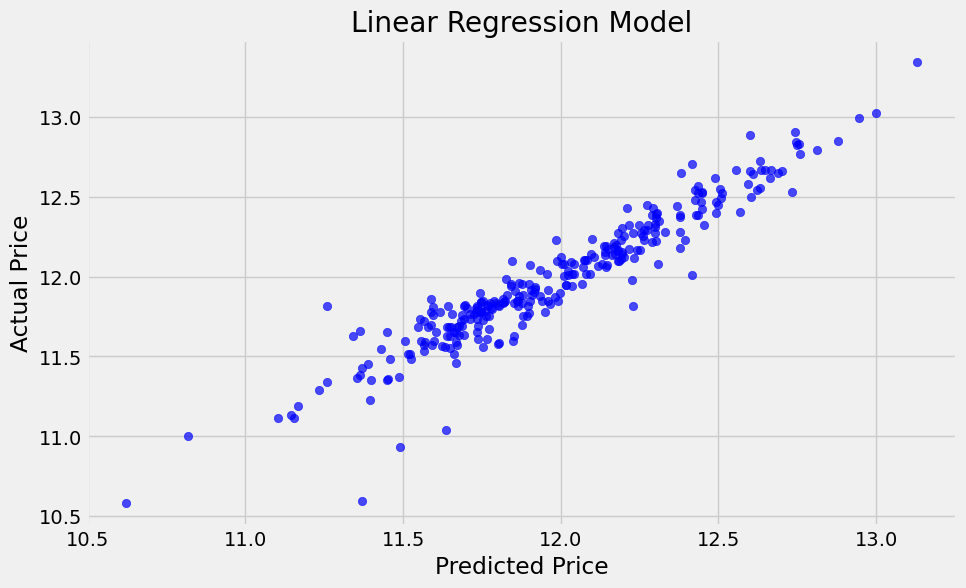

In [26]:
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

# Submission

In [27]:
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)

In [28]:
temp = test.select_dtypes(include = [np.number]).drop(['Id'], axis = 1).interpolate()

In [29]:
predictions = model.predict(temp)

In [30]:
predictions = np.exp(predictions)
submission['SalePrice'] = predictions

In [31]:
submission.to_csv('submission.csv', index = False)